In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from hrdae.models.networks import create_network, HRDAE2dOption, RDAE2dOption, RAE2dOption, AutoEncoder2dNetworkOption
from hrdae.models.networks.motion_encoder import MotionRNNEncoder1dOption, MotionConv2dEncoder1dOption, MotionNormalEncoder1dOption
from hrdae.models.networks.rnn import TCN1dOption, ConvLSTM1dOption, GRU1dOption
from hrdae.dataloaders.datasets import create_dataset, MovingMNISTDatasetOption
from hrdae.dataloaders.transforms import create_transform, MinMaxNormalizationOption


In [3]:
dataset = create_dataset(
    opt=MovingMNISTDatasetOption(
        sequential=True,
        root="../data",
        slice_index=[16, 24, 32, 40, 48],
        content_phase="0",
        motion_phase="0",
        motion_aggregation="none",
    ),
    transform=transforms.Compose([
        create_transform(MinMaxNormalizationOption()),
    ]),
    is_train=False,
)
loader = DataLoader(dataset=dataset, batch_size=8, shuffle=False)

In [4]:
len(dataset)

10000

# MovingMNISTの表示

In [5]:
def show_moving_mnist(i: int = 0):
    for j, data in enumerate(loader):
        if j < i:
            continue
        elif j > i:
            break

        xp = data["xp"]
        n, m, _, _, _ = xp.size()
        fig, axes = plt.subplots(n, m, figsize=(m * 2, n * 2))  # 画像サイズに合わせて調整
        fig.subplots_adjust(hspace=0.1, wspace=0.1)  # サブプロット間のスペースを調整

        for ni in range(n):
            for mi in range(m):
                ax = axes[ni, mi]
                ax.imshow(xp[ni, mi, 0], cmap='gray')  # グレースケールで表示
                ax.axis('off')  # 軸を非表示にする

        plt.show()


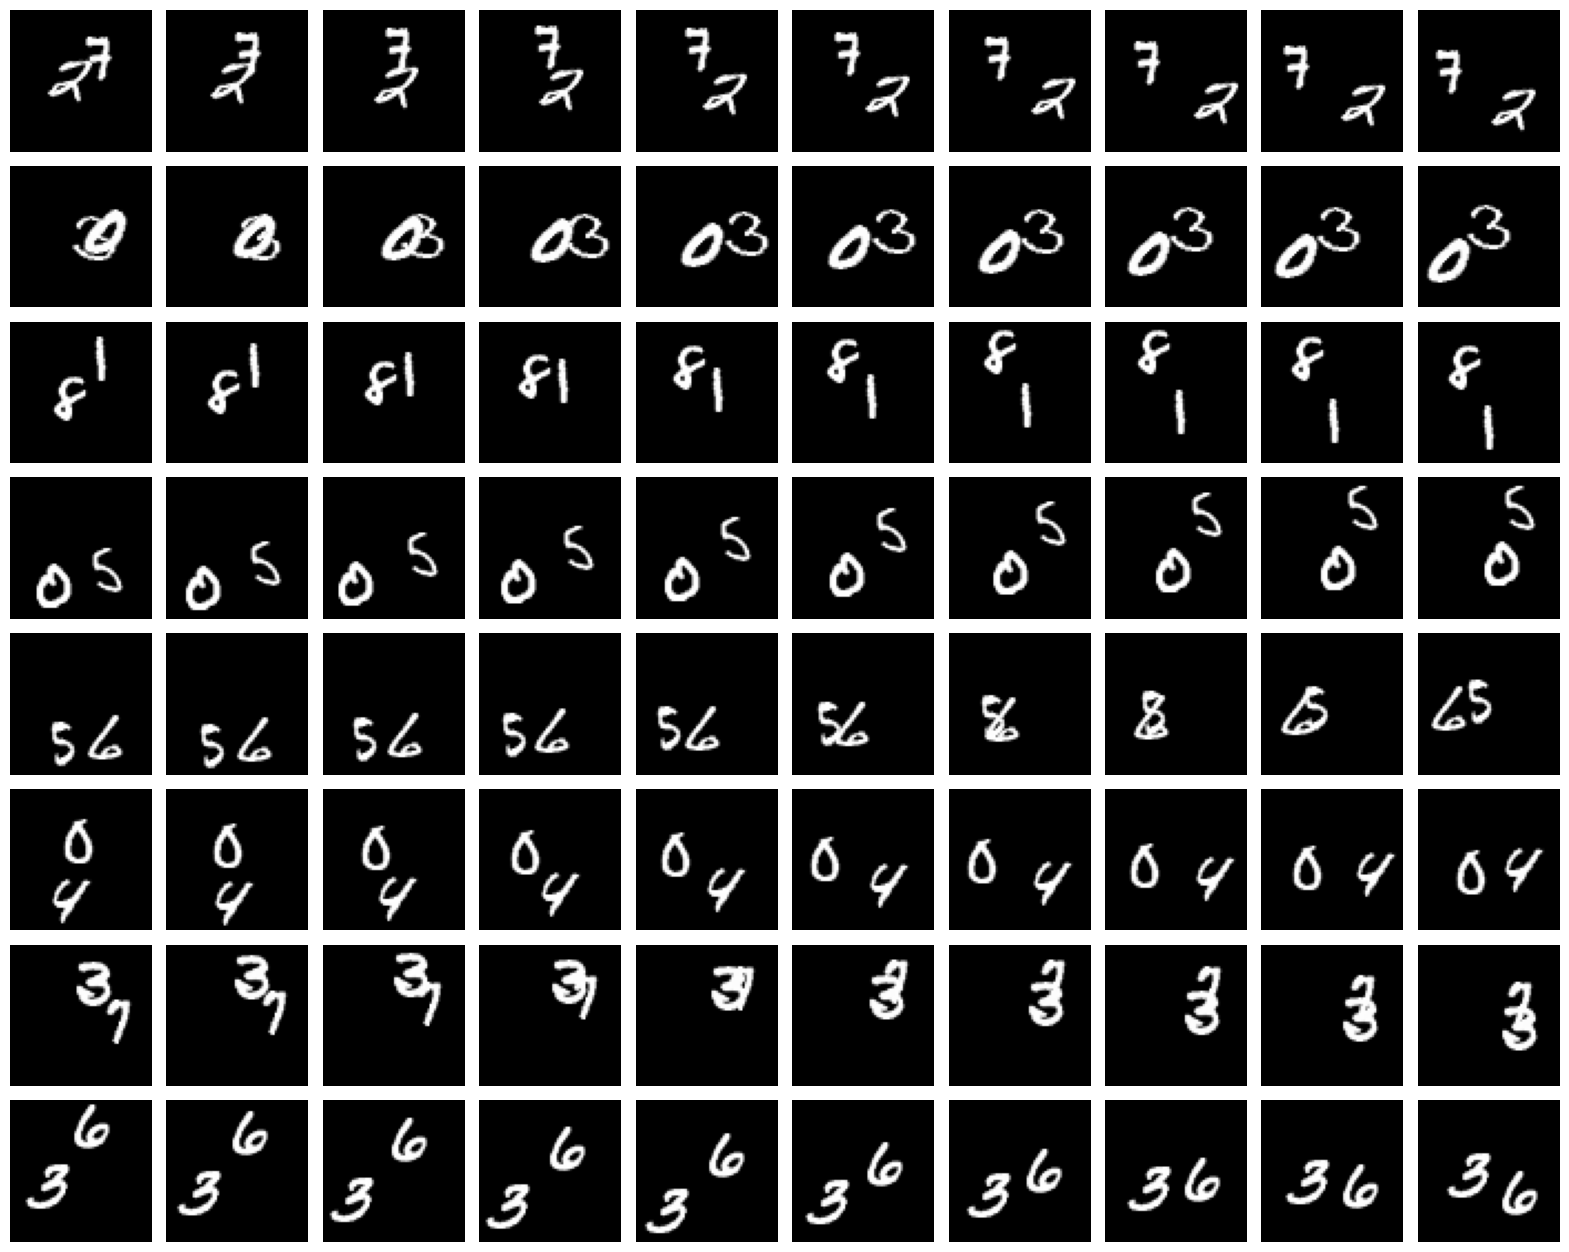

In [6]:
show_moving_mnist()

# contrastive autoencoderの効果測定

In [7]:
def show_distance_by_contrastive(path: str, i: int = 0):
    net = create_network(
        1,
        opt=AutoEncoder2dNetworkOption(
            activation="sigmoid",
            hidden_channels=64,
            latent_dim=32,
            conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 4,
        )
    )
    net.load_state_dict(torch.load(path))
    net.eval()

    for j, data in enumerate(loader):
        if j < i:
            continue
        elif j > i:
            break
        xp = data["xp"]
        y, latent = net(xp.reshape(80, 1, 64, 64))

        latent = latent.clone().detach()

        distances = torch.cdist(latent.view(80, -1), latent.view(80, -1))

        # 距離の最大値で正規化し、距離が小さいほど赤くするために1から引く
        normalized_distances = 1.0 - distances / distances.max()

        # ヒートマップの描画
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_distances, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('Distance Heatmap')
        plt.show()

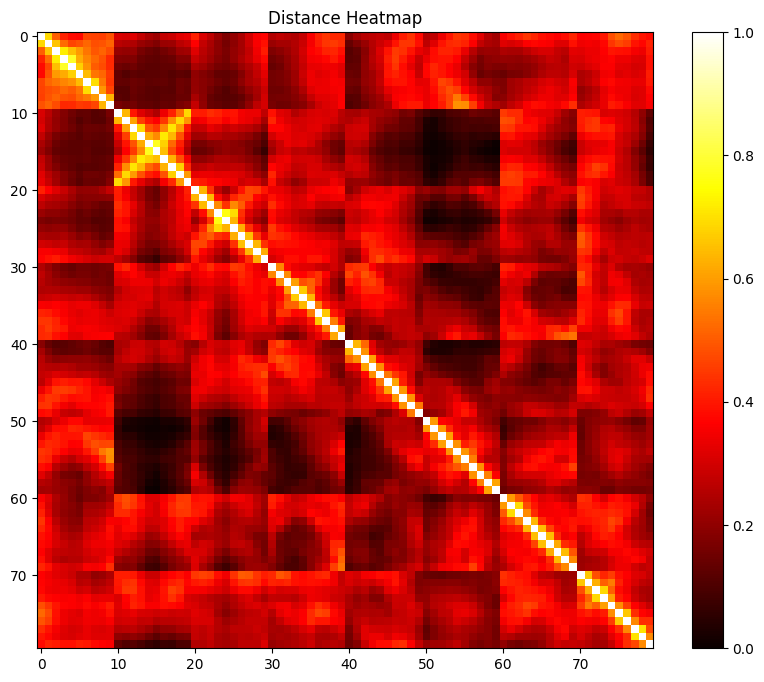

In [8]:
show_distance_by_contrastive("../bin/mmnist/autoencoder2d/contrastive00/best_model.pth", i=2)

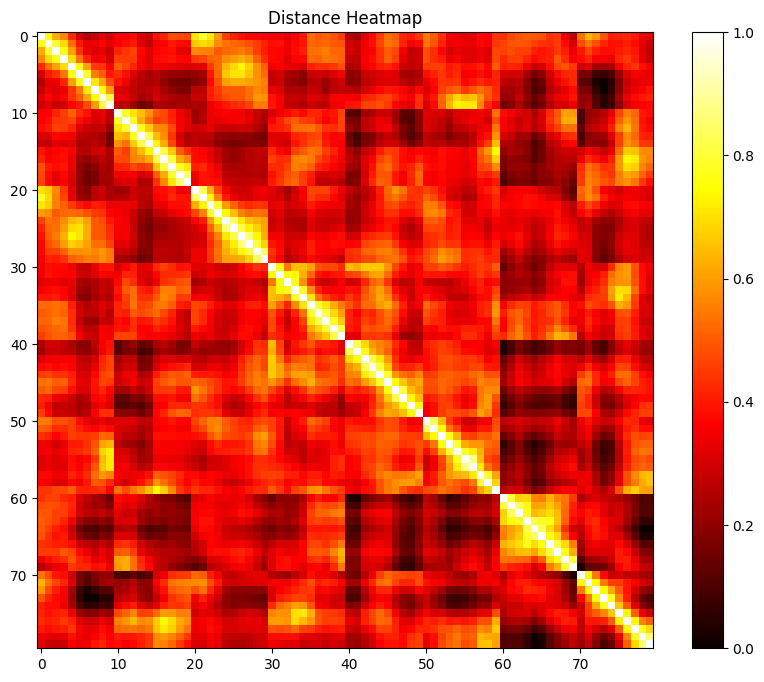

In [9]:
show_distance_by_contrastive("../bin/mmnist/autoencoder2d/contrastive05/best_model.pth")

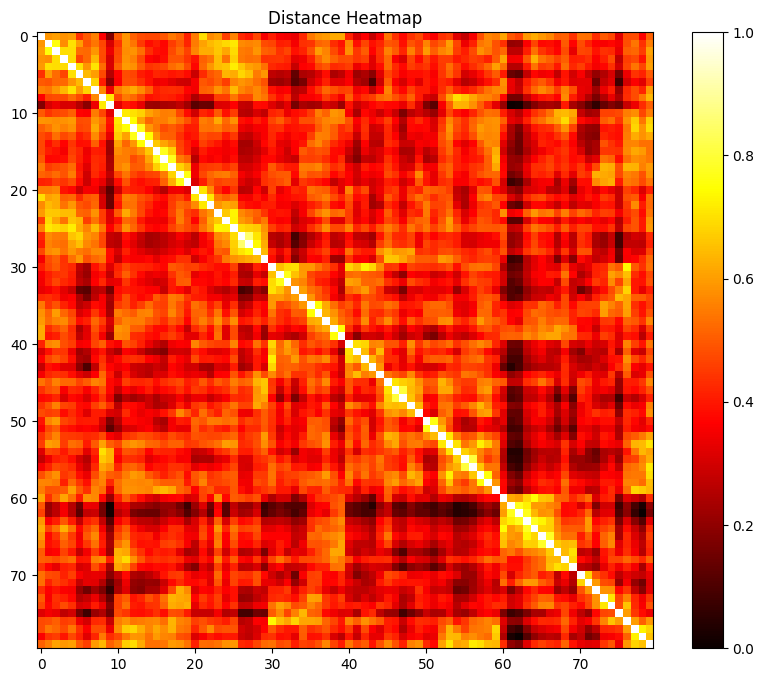

In [10]:
show_distance_by_contrastive("../bin/mmnist/autoencoder2d/contrastive08/best_model.pth")

# 再構成画像の表示

In [13]:
def show_reconstruction(path: str, i: int = 0, typ: str = "conv2d"):
    if typ == "conv2d":
        mopt = MotionConv2dEncoder1dOption(
            in_channels=5,
            hidden_channels=64,
            conv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
            deconv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
        )
    opt = HRDAE2dOption(
        activation="sigmoid",
        hidden_channels=64,
        latent_dim=8,
        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
        motion_encoder=mopt,
        upsample_size=[8, 8],
        in_channels=1,
        aggregator="concatenation",
        cycle=False,
        connection_aggregation="concatenation",
    )
    net = create_network(1, opt)
    net.load_state_dict(torch.load(path))
    net.eval()

    for j, data in enumerate(loader):
        if j < i:
            continue
        elif j > i:
            break

        xm = data["xm"]
        xm_0 = data["xm_0"]
        xp = data["xp"]
        xp_0 = data["xp_0"]

        y, latent, _, cycled_latent = net(xm, xp_0, xm_0)
        y = y.clone().detach()

        n, m, _, _, _ = y.size()
        fig, axes = plt.subplots(n, m, figsize=(m * 2, n * 2))  # 画像サイズに合わせて調整
        fig.subplots_adjust(hspace=0.1, wspace=0.1)  # サブプロット間のスペースを調整

        for ni in range(n):
            for mi in range(m):
                ax = axes[ni, mi]
                ax.imshow(y[ni, mi, 0], cmap='gray')  # グレースケールで表示
                # ax.axis('off')  # 軸を非表示にする
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
            axes[ni, 0].set_ylabel(f'Sample {ni + 1}', rotation=0, ha='right', va='center', size='large', labelpad=20) 

        fig.tight_layout()
        plt.show()

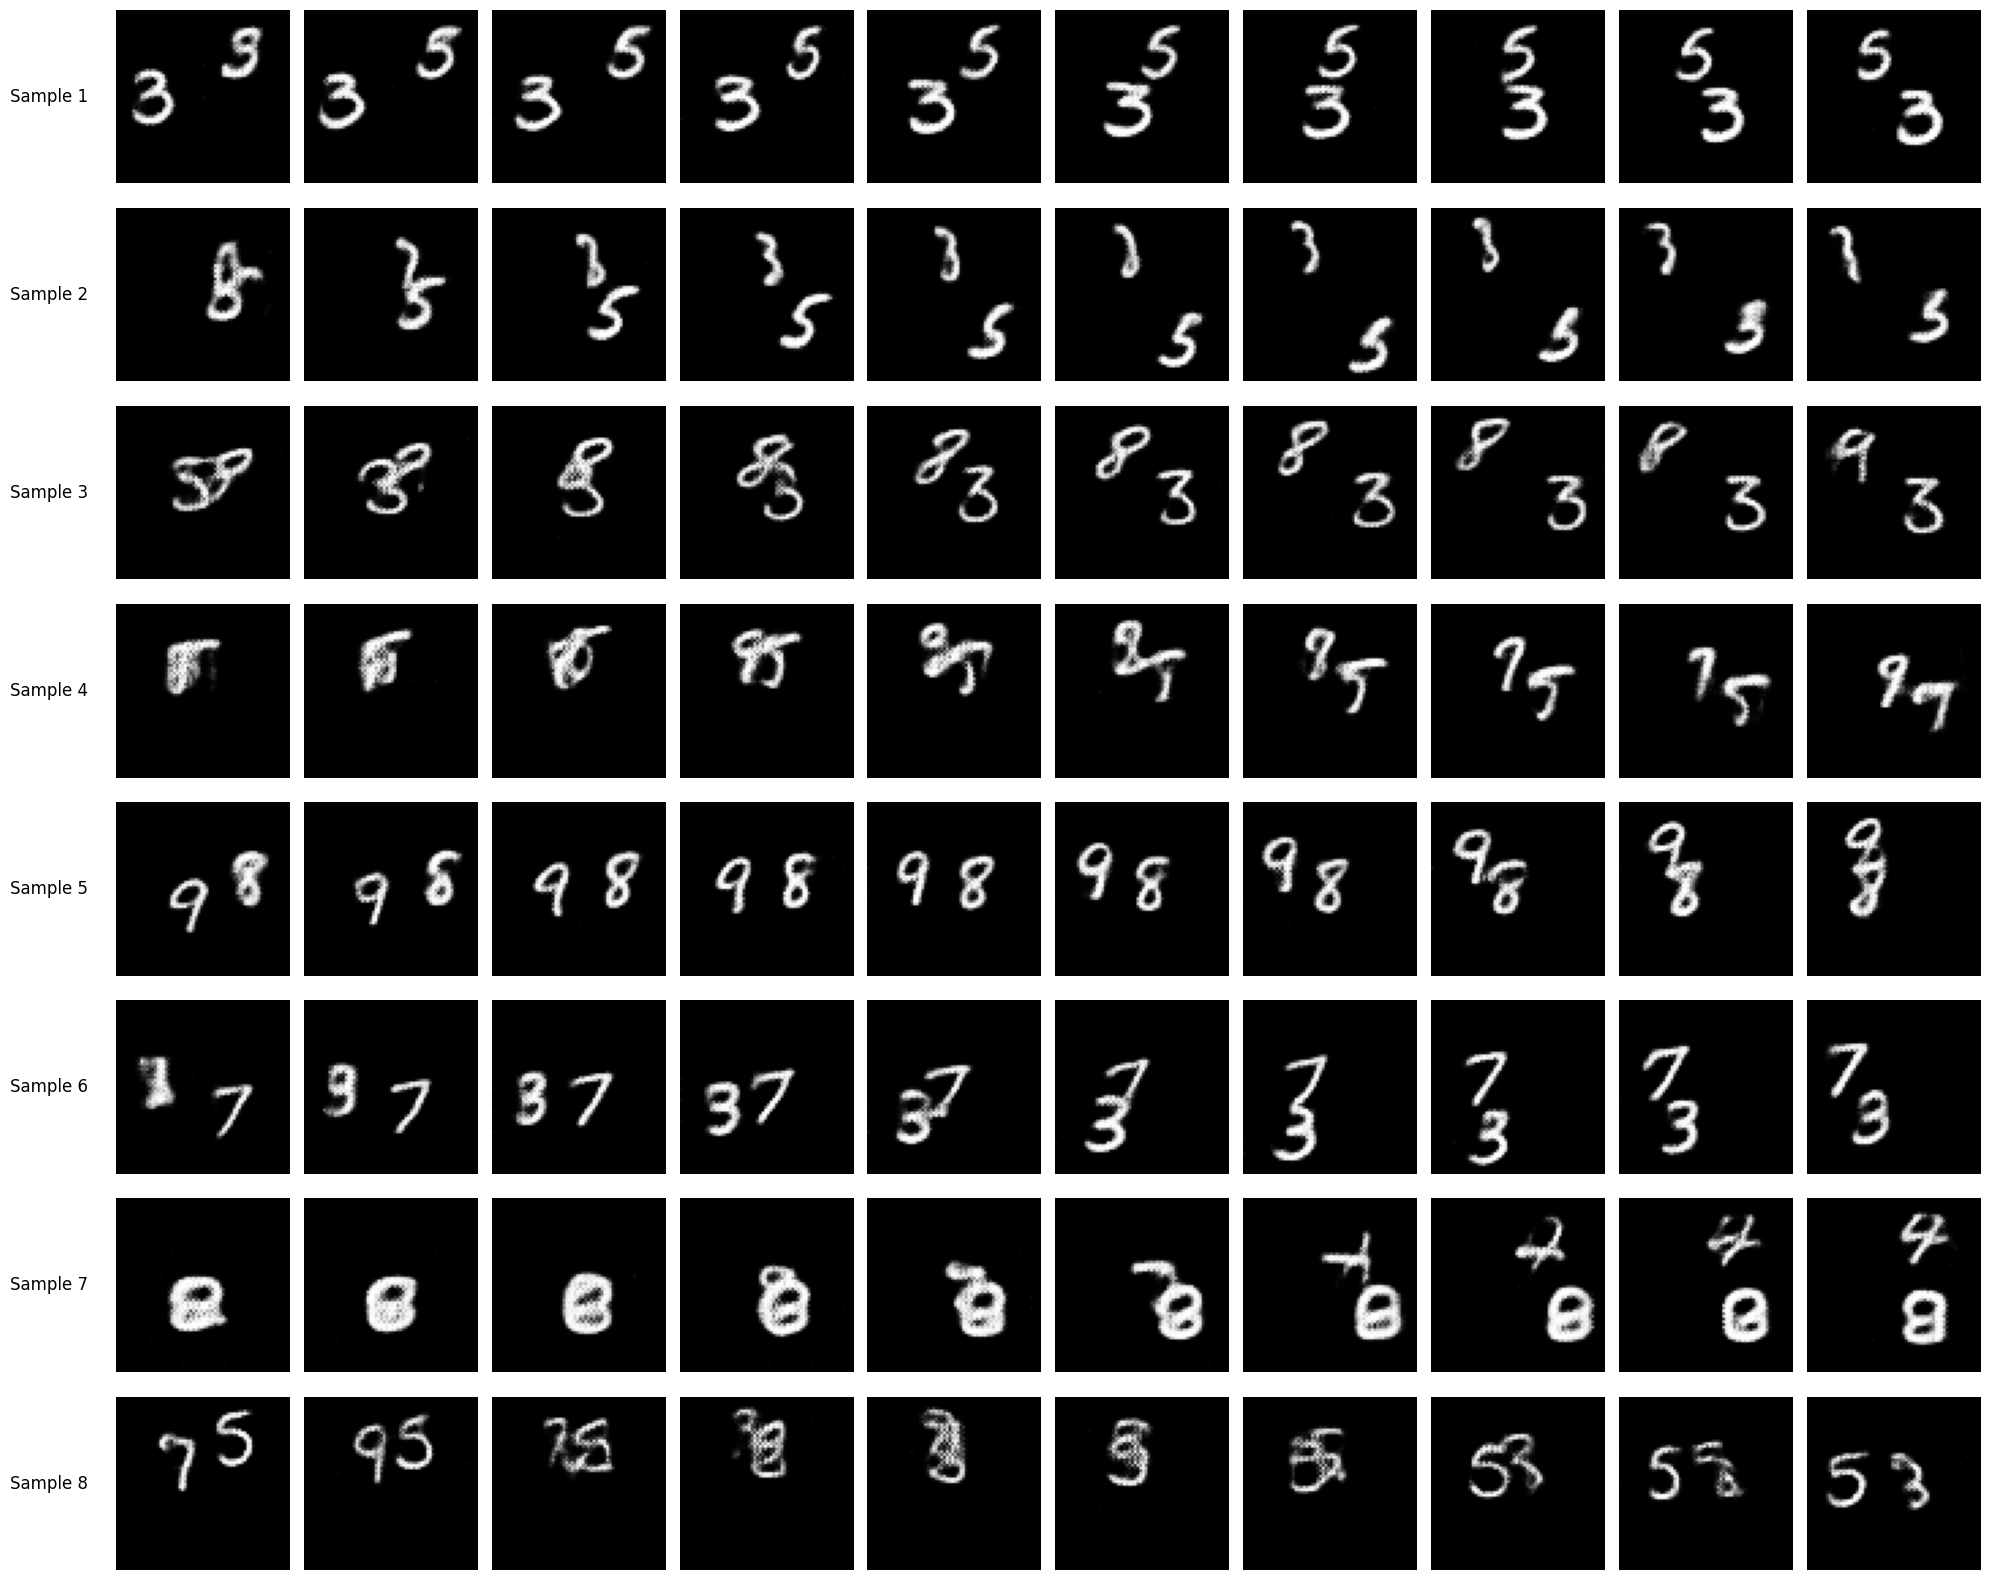

In [14]:
show_reconstruction("../results/finalized/mmnist-hrdae2d-conv2d/p5c5c5/2024-07-11_00-15-34/weights/best_model.pth", i=1)

In [15]:
def show_reconstructions(paths: list[str], i: int = 0, ci: int = 0, si: int = 0):
    for j, data in enumerate(loader):
        if j < i:
            continue
        elif j > i:
            break

        xp_c = data["xp"][ci:ci+1]
        xp_s = data["xp"][si:si+1]
        xm = data["xm"][si:si+1]
        xm_0 = data["xm_0"][si:si+1]
        xp_0 = data["xp_0"][ci:ci+1]

        ys = [xp_c, xp_s]
        labels = ["Content", "State"]
        for path in paths:
            dirname = path.split("results/finalized/")[1]
            name = dirname.split("/")[0]
            loss = dirname.split("/")[1]

            if name == "mmnist-hrdae2d-conv2d":
                opt = HRDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionConv2dEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                    connection_aggregation="concatenation",
                )
                label = "Conv"
            elif name == "mmnist-hrdae2d-conv-lstm1d":
                opt = HRDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionRNNEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        rnn=ConvLSTM1dOption(num_layers=3),
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                    connection_aggregation="concatenation",
                )
                label = "ConvLSTM"
            elif name == "mmnist-hrdae2d-gru1d":
                opt = HRDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionRNNEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        rnn=GRU1dOption(num_layers=3, image_size=8),
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                    connection_aggregation="concatenation",
                )
                label = "GRU"
            elif name == "mmnist-hrdae2d-normal1d":
                opt = HRDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionNormalEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                    connection_aggregation="concatenation",
                )
                label = "No TPM"
            elif name == "mmnist-hrdae2d-tcn1d":
                opt = HRDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionRNNEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        rnn=TCN1dOption(num_layers=3, image_size=8, kernel_size=4, dropout=0),
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                    connection_aggregation="concatenation",
                )
                label = "TCN"
            elif name == "mmnist-rdae2d-conv2d":
                opt = RDAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionConv2dEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    ),
                    upsample_size=[8, 8],
                    in_channels=1,
                    aggregator="concatenation",
                    cycle=False,
                )
                label = "No Hierarchical"
            elif name == "mmnist-rae2d-conv2d":
                opt = RAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionConv2dEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    ),
                    upsample_size=[8, 8],
                )
                label = "Normal AutoEncoder with TPM"
            elif name == "mmnist-rae2d-normal1d":
                opt = RAE2dOption(
                    activation="sigmoid",
                    hidden_channels=64,
                    latent_dim=8,
                    conv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    motion_encoder=MotionNormalEncoder1dOption(
                        in_channels=5,
                        hidden_channels=64,
                        conv_params=[{"kernel_size": [3], "stride": [1, 2], "padding": [1], "output_padding": [0, 1]}] * 3,
                        deconv_params=[{"kernel_size": [3], "stride": [2], "padding": [1], "output_padding": [1]}] * 3,
                    ),
                    upsample_size=[8, 8],
                )
                label = "Normal AutoEncoder"
            else:
                raise KeyError(name)
            
            if loss == "m5m5":
                label += "\n(MSE)"
            elif loss == "p2c5":  # 本当はp: 0.5
                label += "\n(No Cyclic)"
            elif loss == "p2c5m8":
                label += "\n(Perceptual : Cyclic = 2 : 8)"
            elif loss == "p5c0m5":
                label += "\n(No Contrastive in Perceptual)"
            elif loss == "p5c5m5":
                pass
            elif loss == "gp5c5m5":
                label += "\n(Adversarial Loss)"
            elif loss == "p5c5c5":
                label += "\n(Use Contrastive in Cyclic)"
            elif loss == "p8c5m2":
                label += "\n(Perceptual : Cyclic = 8 : 2)"
            elif loss == "p5t5":
                label += "\n(Use Triplet in Cyclic)"

            labels.append(label)

            net = create_network(1, opt)
            net.load_state_dict(torch.load(path))
            net.eval()

            y, latent, _, cycled_latent = net(xm, xp_0, xm_0)
            ys.append(y.clone().detach())

        n = len(ys)
        m = 10
        fig, axes = plt.subplots(n, m, figsize=(m * 2, n * 2))  # 画像サイズに合わせて調整
        fig.subplots_adjust(hspace=0, wspace=0.1)  # サブプロット間のスペースを調整

        for ni in range(n):
            y = ys[ni]
            for mi in range(m):
                ax = axes[ni, mi]
                ax.imshow(y[0, mi, 0], cmap='gray')  # グレースケールで表示
                # ax.axis('off')  # 軸を非表示にする
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
            axes[ni, 0].set_ylabel(labels[ni], rotation=0, ha='right', va='center', size='large', labelpad=20) 

        fig.tight_layout()
        plt.show()

In [21]:
show_reconstructions(
    paths=[
        "../results/finalized/mmnist-hrdae2d-conv2d/p5c5m5/2024-07-08_22-24-04/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/gp5c5m5/2024-07-15_15-49-11/weights/best_generator.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p2c5m8/2024-07-10_16-09-07/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p8c5m2/2024-07-10_13-02-24/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p5c5c5/2024-07-11_00-15-34/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p5c0m5/2024-07-12_14-12-13/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p2c5/2024-07-12_23-31-39/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/m5m5/2024-07-10_19-49-41/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv2d/p5t5/2024-07-14_14-32-39/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-conv-lstm1d/2024-07-13_22-52-47/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-gru1d/2024-07-06_19-07-46/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-tcn1d/p5c5m5/2024-07-07_09-02-34/weights/best_model.pth",
        "../results/finalized/mmnist-hrdae2d-normal1d/2024-07-11_03-18-30/weights/best_model.pth",
        # "../results/finalized/mmnist-rdae2d-conv2d/2024-07-11_11-42-59/weights/best_model.pth", (attention?)
        "../results/finalized/mmnist-rae2d-conv2d/p5m5/2024-07-11_15-39-33/weights/best_model.pth",
        # rae normal?
    ],
    i=0, ci=2, si=7,
)

FileNotFoundError: [Errno 2] No such file or directory: '../results/finalized/mmnist-hrdae2d-conv2d/gpc5m5/2024-07-15_15-49-11/weights/best_generator.pth'